In [16]:
### nb snps in ee normalized by size of exon 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
from statannot import add_stat_annotation
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42

### EE
df = pd.read_csv("/mnt/project/exonhancer/ZENODO_REPO_DISCARDED_JC_DONT_TOUCH/PanCancer_analysis/treat_mc3_file/ee_hg19_ovlp_mc3_af.tsv", sep='\t')

ee_group_tf = {}
with open("/home/mouren/Data/final_files_tokeep/notes/ee_grouped_tf") as file:
    for line in file:           
        ee_group_tf[line.strip().split()[0]] = line.strip().split()[1]

grouped = df.groupby(df.columns[3])
res_ratio_per_group = {}
ratios_ee = []
for name, group in grouped:
    start = int(group.iloc[0, 1])
    end = int(group.iloc[0, 2])
    id = group.iloc[0, 3] 
    size = end - start

    if size > 0:
        ratio = len(group) / size
        ratios_ee.append(ratio)

        if ee_group_tf[id] not in res_ratio_per_group:
            res_ratio_per_group[ee_group_tf[id]] = [ratio]
        else:
            res_ratio_per_group[ee_group_tf[id]].append(ratio)
    else:
        ratios_ee.append(float('nan'))  # Or handle zero/invalid size as needed

### NEG
df = pd.read_csv("/mnt/project/exonhancer/ZENODO_REPO_DISCARDED_JC_DONT_TOUCH/PanCancer_analysis/treat_mc3_file/neg_hg19_ovlp_mc3_af.tsv", sep='\t')

grouped = df.groupby(df.columns[3])
ratios_neg = []
for name, group in grouped:
    start = int(group.iloc[0, 1])
    end = int(group.iloc[0, 2])
    size = end - start

    if size > 0:
        ratio = len(group) / size
        ratios_neg.append(ratio)
    else:
        ratios_neg.append(float('nan'))  # Or handle zero/invalid size as needed

### POS
df = pd.read_csv("/mnt/project/exonhancer/ZENODO_REPO_DISCARDED_JC_DONT_TOUCH/PanCancer_analysis/treat_mc3_file/pos_hg19_ovlp_mc3_af.tsv", sep='\t')

grouped = df.groupby(df.columns[3])
ratios_pos = []
for name, group in grouped:
    start = int(group.iloc[0, 1])
    end = int(group.iloc[0, 2])
    size = end - start

    if size > 0:
        ratio = len(group) / size
        ratios_pos.append(ratio)
    else:
        ratios_pos.append(float('nan'))  # Or handle zero/invalid size as needed


In [33]:
while len(ratios_neg) < 13197:
    ratios_neg.append(0)

while len(ratios_ee) < 13469:
    ratios_ee.append(0)

for key,val in res_ratio_per_group.items():
    while len(val) < 1348:
        val.append(0)
        res_ratio_per_group[key].append(0)

In [18]:
import numpy as np

values_array = np.array(ratios_ee)

# Compute quantiles
lower_quantile = np.quantile(values_array, 0.05)
upper_quantile = np.quantile(values_array, 0.95)

# Filter values between 5th and 95th percentile
filtered_values = values_array[
    (values_array >= lower_quantile) & (values_array <= upper_quantile)
]
ratios_ee_filtered = filtered_values.tolist()

values_array = np.array(ratios_neg)
lower_quantile = np.quantile(values_array, 0.05)
upper_quantile = np.quantile(values_array, 0.95)
filtered_values = values_array[
    (values_array >= lower_quantile) & (values_array <= upper_quantile)
]
ratios_neg_filtered = filtered_values.tolist()

values_array = np.array(ratios_pos)
lower_quantile = np.quantile(values_array, 0.05)
upper_quantile = np.quantile(values_array, 0.95)
filtered_values = values_array[
    (values_array >= lower_quantile) & (values_array <= upper_quantile)
]
ratios_pos_filtered = filtered_values.tolist()


In [35]:
df_group = pd.DataFrame([(key, value) for key, values in res_ratio_per_group.items() for value in values],
                  columns=["GroupByTF", "TCGA_Variants"])
df_group['GroupByTF'] = df_group['GroupByTF'].astype(int)


### kruskal test to check if diff between nb snp per decile ee
from scipy.stats import kruskal
group_data = [df_group[df_group['GroupByTF'] == g]['TCGA_Variants'] for g in range(1, 11)]
stat, p_value = kruskal(*group_data)
print(f"Kruskal-Wallis H-statistic: {stat}, p-value: {p_value}")


lower_quantile = df_group['TCGA_Variants'].quantile(0.05)  # Lower 5%
upper_quantile = df_group['TCGA_Variants'].quantile(0.95)  # Upper 95%

filtered_data = df_group[
    (df_group['TCGA_Variants'] >= lower_quantile) & (df_group['TCGA_Variants'] <= upper_quantile)
]

Kruskal-Wallis H-statistic: 93.1466542430691, p-value: 3.7970441836396197e-16


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Ctrl- v.s. cEEs: t-test independent samples with Bonferroni correction, P_val=4.068e-149 stat=-2.619e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 10: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.606e-03 stat=8.472e+00


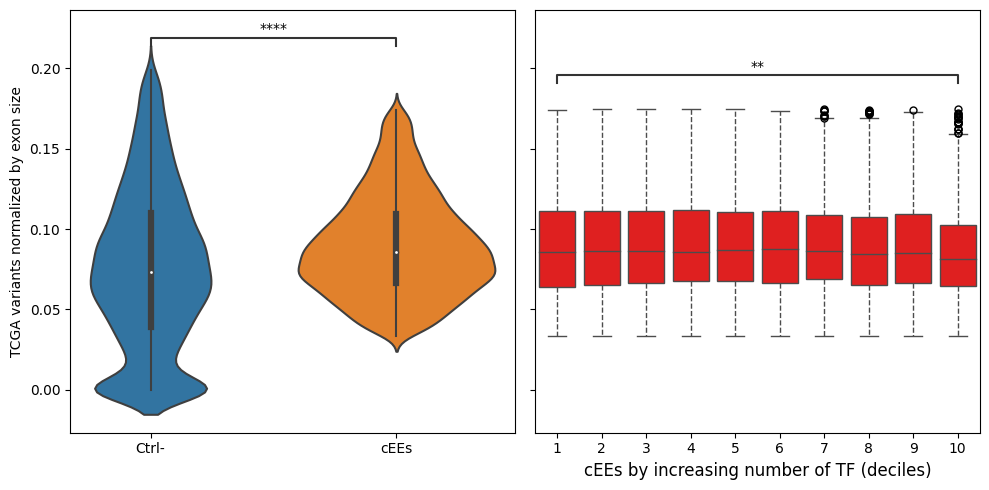

In [40]:
# Create a figure and two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5),sharey=True)

# --- First Plot: Violin Plot ---
sns.violinplot(x='group', y='value', data=data, ax=ax1, inner="box", order=["Ctrl-","cEEs"])

# Add statistical annotations
add_stat_annotation(
    ax1,
    data=data,
    x='group', y='value',
    box_pairs=[("cEEs", "Ctrl-"),],
    test='t-test_ind',
    text_format='star',
    loc='inside',
    verbose=1, order=["Ctrl-","cEEs"]
)

#ax1.set_title('gnomAD SNPs by EE')
ax1.set_ylabel('TCGA variants normalized by exon size')
ax1.set_xlabel(None)

# --- Second Plot: Box Plot ---
sns.boxplot(
    data=filtered_data,
    x='GroupByTF',
    y='TCGA_Variants',
    color='red',
    showfliers=True,
    linewidth=1,
    whiskerprops={'linestyle': '--'},
    flierprops={
        'marker': 'o',
        'markerfacecolor': 'none',
        'markeredgecolor': 'black',
        'markersize': 5
    },
    ax=ax2  # Use ax2 for the second plot
)

add_stat_annotation(
                ax2, data=filtered_data, x='GroupByTF', y="TCGA_Variants",
                box_pairs=[(1, 10)],
                order=list(range(1, 11)),
                test='Kruskal',  # Kruskal-Wallis test
                text_format='star',
                loc='inside',
            )#verbose=0)

ax2.set_ylabel(None)
ax2.set_xlabel("cEEs by increasing number of TF (deciles)", fontsize=12)
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

fig.tight_layout()

plt.savefig("/home/mouren/Images/tls1/revisions/rev_1_pt13_nb_tcga_variants.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/tls1/revisions/rev_1_pt13_nb_tcga_variants.png", format="png", bbox_inches="tight", dpi=450)


plt.show()
